---

# <center>GoogleNet (Inception V1)</center>

---

## 1. Configurações de Ambiente 

<p style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.5; color: #333; text-align: justify;">Antes de começarmos a construir e treinar nossa rede neural, precisamos configurar nosso ambiente. Isso envolve várias etapas importantes que garantem que nosso código seja executado corretamente e nossos experimentos sejam reproduzíveis.</p>

### 1.1 Instalação e Carga de Pacotes

<div style="background-color: #f2f2f2; border-radius: 20px; margin: 10px; padding: 10px;">
<ul>
    <li><p style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.5; color: #333; text-align: justify;"><strong>os</strong>: Esta é uma biblioteca padrão do Python que fornece funções para interagir com o sistema operacional, incluindo a leitura de variáveis de ambiente, manipulação de diretórios e arquivos.</p></li>
    <li><p style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.5; color: #333; text-align: justify;"><strong>warnings</strong>: Outra biblioteca padrão do Python usada para emitir avisos e controlar se eles são ignorados ou não.</p></li>
    <li><p style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.5; color: #333; text-align: justify;"><strong>numpy</strong>: Uma biblioteca fundamental para a computação científica em Python. Ela fornece suporte para arrays multidimensionais, matrizes e uma grande coleção de funções matemáticas de alto nível.</p></li>
    <li><p style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.5; color: #333; text-align: justify;"><strong>seaborn</strong> e <strong>matplotlib</strong>: São bibliotecas de visualização de dados em Python que fornecem uma interface de alto nível para desenhar gráficos estatísticos atraentes e informativos.</p></li>
    <li><p style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.5; color: #333; text-align: justify;"><strong>torchvision</strong>: Uma parte do ecossistema PyTorch, torchvision é usada para carregar e preparar conjuntos de dados de imagens, além de fornecer alguns modelos pré-treinados.</p></li>
    <li><p style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.5; color: #333; text-align: justify;"><strong>torch</strong>: É uma biblioteca de aprendizado profundo de código aberto que fornece uma interface flexível e eficiente para algoritmos de aprendizado profundo e usa a biblioteca de matrizes Tensor do Google.</p></li>
    <li><p style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.5; color: #333; text-align: justify;"><strong>torchmetrics</strong>: É uma biblioteca que fornece métricas para avaliação de modelos PyTorch, neste caso, a precisão da classificação.</p></li>
    <li><p style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.5; color: #333; text-align: justify;"><strong>lightning</strong>: PyTorch Lightning é uma estrutura leve que organiza o código PyTorch, fornecendo abstração para treinamento, validação, teste e previsão enquanto mantém total controle e simplicidade.</p></li>
</ul>
</div>

In [1]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.6 MB/s eta 0:00:00a 0:00:01


In [2]:
# Ambiente de desenvolvimento
import os 
import warnings

# Álgebra Linear & Math
import numpy as np
import pandas as pd

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# Pytorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

# Métricas de Avaliação
from torchmetrics.classification import Accuracy

# Lightning
import lightning as pl
from lightning.pytorch import Trainer
from lightning import LightningModule
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

# Torchvision
import torchvision
from torchvision.models import googlenet
from torchvision.datasets import CIFAR100
from torchvision.transforms import Resize
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import ColorJitter
from torchvision.transforms import RandomRotation
from torchvision.transforms import RandomHorizontalFlip

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# Ignorando avisos desnecessários
warnings.filterwarnings("ignore")

### 1.2 Garantindo a Reprodutibilidade dos Experimentos

In [4]:
def set_seed(seed=1996):
    # CPU
    np.random.seed(seed)
    torch.manual_seed(seed)
    pl.seed_everything(seed)
    os.environ["PYTHONHASH"] = str(seed)
    
    # GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Configurações extras para tornar os experimentos deterministicos
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
set_seed()

INFO: Seed set to 1996


### 1.3 Definindo o dispositivo (CPU OU GPU)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"O dispositivo usado: {device}")

O dispositivo usado: cuda


## 2. Carga e Pré-processamento das Imagens

In [6]:
class GetDataLoaders(object):
    
    # Método construtor
    def __init__(self):
        self.BATCH_SIZE  = 126 if torch.cuda.is_available() else 64
        self.NUM_WORKERS = int(os.cpu_count()/2)
        
    # Obtendo a média e desvio padrão das imagens
    def get_mean_and_std(self):
        
        # Carregando imagens de treino
        trainset   = CIFAR100(root="./data", train=True, transform=ToTensor(), download=True)
        train_data = DataLoader(dataset=trainset, batch_size=self.BATCH_SIZE, shuffle=True, num_workers=self.NUM_WORKERS)
        
        # Obtendo o número de canais de cores das imagens
        n_channels = next(iter(train_data))[0].size(1)
        
        # Criando os tensores que armazenarão as médias e desvios padrão
        mean, std = torch.zeros(n_channels), torch.zeros(n_channels)
        
        # Obtendo a média e desvio padrão das imagens
        for inputs, targets in train_data:
            for i in range(n_channels):
                mean[i] += inputs[:, i, :, :].mean()
                std[i]  += inputs[:, i, :, :].std()
        mean.div_(len(train_data))
        std.div_(len(train_data))
        
        # Retornando os valores de média e desvio padrão
        return mean, std
    
    # Obtendo transformadores
    def get_transformers(self):
        
        # Obtendo média e desvio padrão das imagens
        mean, std = self.get_mean_and_std()
        
        # Transformações para dados de treino
        train_transform = Compose([
            Resize((224, 224)),
            RandomHorizontalFlip(),
            RandomRotation(15),
            ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            ToTensor(),
            Normalize(mean, std)
        ])
        
        # Transformações para dados de validação
        valid_transform = Compose([
            Resize((224, 224)),
            ToTensor(),
            Normalize(mean, std)
        ])
        
        # Retornando os transformadores
        return train_transform, valid_transform
    
    # Obtendo os DataLoaders de treino e validação
    def get_dataloaders(self):
        
        # Obtendo os transformadores
        train_transform, valid_transform = self.get_transformers()
        
        # Carregando imagens de treino
        trainset   = CIFAR100(root="./data", train=True, transform=train_transform, download=True)
        train_data = DataLoader(dataset=trainset, batch_size=self.BATCH_SIZE, shuffle=True, num_workers=self.NUM_WORKERS)
        
        # Carregando imagens de validação
        validset   = CIFAR100(root="./data", train=False, transform=valid_transform, download=True)
        valid_data = DataLoader(dataset=validset, batch_size=self.BATCH_SIZE, shuffle=True, num_workers=self.NUM_WORKERS)
        
        # Retornando os DataLoaders
        return train_data, valid_data
    
# Obtendo os DataLoaders
train_data, valid_data = GetDataLoaders().get_dataloaders()

100%|██████████| 169001437/169001437 [00:15<00:00, 11218708.11it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


### 2.1 Visualizando Imagens do CIFAR-10 Transformadas

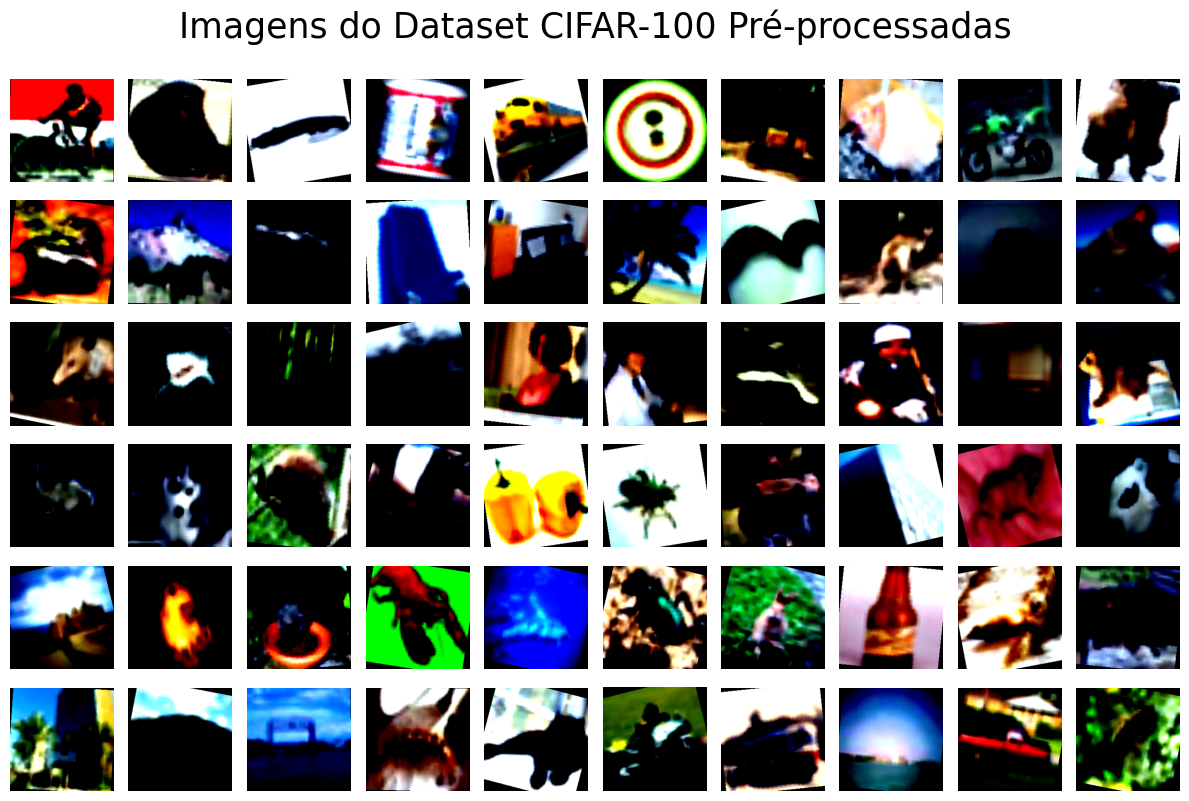

In [7]:
# Carrega primeiro batch de imagens
images, labels = next(iter(train_data))

# Visualizando as primeiras imagens
fig, axes = plt.subplots(nrows=6, ncols=10, figsize=(12, 8))
fig.suptitle("Imagens do Dataset CIFAR-100 Pré-processadas", fontsize=25, y=1) 

for i, ax in enumerate(axes.flatten()):
    img = images[i].numpy()
    img = np.transpose(img, (1, 2, 0)) # Transpõe a imagem

    # Recorta os valores dos dados da imagem para o intervalo [0, 1]
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.axis("off")

plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Ajustar a distância vertical e horizontal entre as subtramas
plt.tight_layout()
plt.show()

## 3. GoogleNet Pré-treinado

### 3.1 Carrega o GoogleNet e Define os Processos de Treinamento

In [8]:
def load_GoogleNet(pretrained=True):
    
    # Carrega modelo pré-treinado
    modelo         = googlenet(pretrained=pretrained)
    
    # Habilita o ajuste fino de todas as camadas do modelo
    for param in modelo.parameters():
        param.requires_grad = True
        
    # Adiciona a camada de saída
    modelo.fc = nn.Linear(in_features=1024, out_features=100, bias=True)
    
    # Coloca o modelo na GPU
    if torch.cuda.is_available():
        modelo.cuda()
        
    # Retorna o modelo pré-treinado
    return modelo

In [9]:
class GoogleNet(LightningModule):
    
    # Método construtor
    def __init__(self):
        super().__init__()
        self.model    = load_GoogleNet()
        self.accuracy = Accuracy(task="multiclass", num_classes=100).to(device)
        
    # Método forward
    def forward(self, x):
        return self.model(x)
    
    # Método de treinamento
    def training_step(self, batch, batch_idx):
        x, y   = batch
        logits = self(x)
        loss   = F.cross_entropy(logits, y)
        acc    = self.accuracy(logits, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc",  acc,  on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    # Método de teste
    def test_step(self, batch, batch_idx):
        x, y   = batch
        logits = self(x)
        loss   = F.cross_entropy(logits, y)
        acc    = self.accuracy(logits, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_acc",  acc,  on_step=False, on_epoch=True, prog_bar=True)

    
    # Método de validação
    def validation_step(self, batch, batch_idx):
        x, y   = batch
        logits = self(x)
        loss   = F.cross_entropy(logits, y)
        acc    = self.accuracy(logits, y)
        self.log("valid_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("valid_acc",  acc,  on_step=False, on_epoch=True, prog_bar=True)
    
    # Método de otimização
    def configure_optimizers(self): 
        
        # Otimizador
        optimizer = optim.AdamW(params=self.parameters(), lr=0.001, weight_decay=0.01)
        
        # Lr_Scheduler
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.5)
        
        # Retornando as configurações de otimização
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": lr_scheduler, "interval": "epoch"}}
    
# Instanciando a classe ModeloResNet18
modelo = GoogleNet().to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 88.0MB/s]


### 3.2 Configurações de Treinamento

In [10]:
# Definindo o checkpoint
checkpoint_callback = ModelCheckpoint(
    dirpath='best/',
    monitor='valid_acc',
    mode='max',
    filename='best-model',
    save_top_k=1,
    verbose=True,
)

# Definindo o treinador
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None, 
    max_epochs=100, 
    logger=CSVLogger(save_dir="./logs"),
    callbacks=[EarlyStopping(monitor="valid_acc", patience=3, mode="max"), checkpoint_callback]
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


### 3.3 Realiza o Treinamento

In [11]:
# Realizando o treinamento
trainer.fit(modelo, train_dataloaders=train_data, val_dataloaders=valid_data)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params
------------------------------------------------
0 | model    | GoogLeNet          | 5.7 M 
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
22.810    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 397: 'valid_acc' reached 0.61010 (best 0.61010), saving model to '/kaggle/working/best/best-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 794: 'valid_acc' reached 0.65710 (best 0.65710), saving model to '/kaggle/working/best/best-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1191: 'valid_acc' reached 0.70330 (best 0.70330), saving model to '/kaggle/working/best/best-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1588: 'valid_acc' reached 0.71760 (best 0.71760), saving model to '/kaggle/working/best/best-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1985: 'valid_acc' reached 0.72790 (best 0.72790), saving model to '/kaggle/working/best/best-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 2382: 'valid_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 2779: 'valid_acc' reached 0.74430 (best 0.74430), saving model to '/kaggle/working/best/best-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 3176: 'valid_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 3573: 'valid_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 3970: 'valid_acc' was not in top 1


## 4. Avaliação do Modelo GoogleNet

In [13]:
# Carregando os pesos do modelo
checkpoint = torch.load("/kaggle/working/best/best-model.ckpt")
modelo.load_state_dict(checkpoint['state_dict'])

# Rsultados para dados de validação
trainer.test(modelo, valid_data)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7443000078201294     │
│         test_loss         │    0.9197068214416504     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9197068214416504, 'test_acc': 0.7443000078201294}]

In [14]:
def load_and_process_metrics(trainer):
    # Carrega métricas de treinamento e validação
    metricas = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
    metricas.set_index('epoch', inplace=True)

    # Deletando os passos individuais
    del metricas["step"]; del metricas['test_loss']; del metricas['test_acc']

    # Removendo valores NaN
    df_val_loss_acc    = metricas[['valid_loss', 'valid_acc']].dropna()
    df_train_loss_acc  = metricas[['train_loss', 'train_acc']].dropna()

    # Concatenando os dataframes
    metricas = df_train_loss_acc.join(df_val_loss_acc)
    
    return metricas

# Carregando as métricas de treino e validação por época
metricas = load_and_process_metrics(trainer)

# Salvando arquivo csv com as métricas de validação
metricas.to_csv('metricas.csv', index=False)

### 4.1 Desempenho do Modelo para Dados de Validação

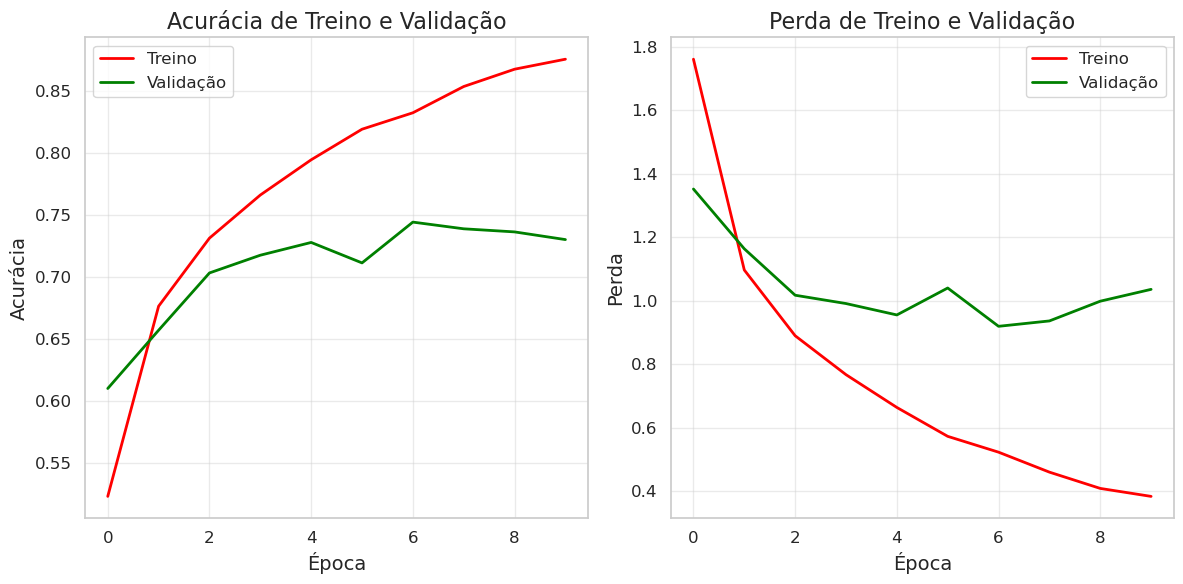

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de estilo
sns.set(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"

# Cria a figura
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plota a acurácia
axs[0].plot(metricas['train_acc'], label="Treino", color="red", linewidth=2)
axs[0].plot(metricas['valid_acc'], label="Validação", color="green", linewidth=2)
axs[0].set_title("Acurácia de Treino e Validação", fontsize=16)
axs[0].set_xlabel("Época", fontsize=14)
axs[0].set_ylabel("Acurácia", fontsize=14)
axs[0].legend(fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].grid(alpha=0.4)

# Plota a perda
axs[1].plot(metricas['train_loss'], label="Treino", color="red", linewidth=2)
axs[1].plot(metricas['valid_loss'], label="Validação", color="green", linewidth=2)
axs[1].set_title("Perda de Treino e Validação", fontsize=16)
axs[1].set_xlabel("Época", fontsize=14)
axs[1].set_ylabel("Perda", fontsize=14)
axs[1].legend(fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].grid(alpha=0.4)

# Mostra o gráfico
plt.tight_layout()
plt.show()